In [1]:
from torchvision.datasets import MNIST
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset

In [2]:
from test_utils import compute_log_likelihood_importance_sampling, compute_log_likelihood_monte_carlo, \
                        model_test_loss, log_mean_exp
from train_utils import train_model
from losses import binary_crossentropy_loss
from mask_generators import generate_horizontal_line
from nn_utils import MemData, Reshape, MergeSkipConnection, AddSkipConnection, ResNetBlock

In [3]:
def generate_horizontal_line_MNIST(batch_size):
    return generate_horizontal_line(batch_size, 28, 28, 3)

In [4]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255)

In [5]:
train_data.tensors = (train_data.tensors[0].round(),)
test_data.tensors = (test_data.tensors[0].round(),)

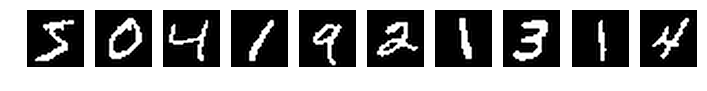

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 28, 28)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(Variable(train_data[:10][0]))

In [7]:
class UM(nn.Module):
    def __init__(self, loss, network):
        super(type(self), self).__init__()
        self.loss = loss
        self.network = network

    def batch_loss(self, batch, weights=None, K=1):
        res = 0
        for i in range(K):
            x, b = batch
            b = b * torch.bernoulli(torch.ones_like(b).cuda() * torch.rand(b.size(0), 1).cuda()).cuda()
            x, b = Variable(x), Variable(b)
            data = torch.cat([x * (1 - b), b], 1)
            x_distr = self.network(data)
            res += self.loss(x, x_distr, b).mean() / K
        return res

    def generate_samples(self, x, b, K):
        n, d = x.shape
        x = x * (1 - b)
        x = x.view(n, 1, d).repeat(1, K, 1).view(-1, d)
        b = b.view(n, 1, d).repeat(1, K, 1).view(-1, d)
        while (b.sum() != 0):
            data = torch.cat([x, b], 1)
            x_distr = self.network(Variable(data)).data
            b_sum = b.sum(1, True)
            i_idx = torch.nonzero(b_sum)[:, 0]
            j_idx = torch.multinomial(b[i_idx] / b_sum[i_idx], 1).view(-1)
            x[i_idx, j_idx] = torch.bernoulli(x_distr[i_idx, j_idx])
            b[i_idx, j_idx] = 0
        return x.view(n, K, d)

In [8]:
skip_connection_0 = MemData()
skip_connection_1 = MemData()
skip_connection_2 = MemData()
skip_connection_3 = MemData()
network = nn.Sequential(
    Reshape(2, 28, 28),
    skip_connection_0,
    ResNetBlock(2, 6, 2),
    skip_connection_1,
    ResNetBlock(6, 16, 2),
    skip_connection_2,
    Reshape(-1),
    nn.Linear(784, 256),
    nn.LeakyReLU(inplace=True),
    skip_connection_3,
    nn.Linear(256, 16),
    nn.LeakyReLU(inplace=True),
    nn.Linear(16, 256),
    nn.LeakyReLU(),
    MergeSkipConnection(skip_connection_3),
    nn.Linear(256 + 256, 784),
    nn.LeakyReLU(),
    Reshape(16, 7, 7),
    MergeSkipConnection(skip_connection_2),
    nn.Upsample(scale_factor=2),
    ResNetBlock(16 + 16, 6),
    MergeSkipConnection(skip_connection_1),
    nn.Upsample(scale_factor=2),
    MergeSkipConnection(skip_connection_0),
    ResNetBlock(6 + 6 + 2, 6),
    nn.Conv2d(6, 1, 1),
    nn.Sigmoid(),
    Reshape(-1),
)

In [9]:
model = UM(binary_crossentropy_loss, network)

In [10]:
%time model_um = train_model(train_data, model, generate_horizontal_line_MNIST, \
                             batch_size=200, num_epochs=30, learning_rate=1e-3)

Epoch 0 Train loss -47.687862396240234 Batch 300 of 300           
Epoch 1 Train loss -40.612335205078125 Batch 300 of 300           
Epoch 2 Train loss -45.733089447021484 Batch 300 of 300           
Epoch 3 Train loss -40.29722213745117 Batch 300 of 300            
Epoch 4 Train loss -35.65074920654297 Batch 300 of 300            
Epoch 5 Train loss -40.48788070678711 Batch 300 of 300            
Epoch 6 Train loss -35.0073127746582 Batch 300 of 300             
Epoch 7 Train loss -35.508544921875 Batch 300 of 300              
Epoch 8 Train loss -38.568485260009766 Batch 300 of 300           
Epoch 9 Train loss -32.62111282348633 Batch 300 of 300           
Epoch 10 Train loss -33.758949279785156 Batch 300 of 300           
Epoch 11 Train loss -31.194372177124023 Batch 300 of 300           
Epoch 12 Train loss -33.06964111328125 Batch 300 of 300            
Epoch 13 Train loss -33.63426971435547 Batch 300 of 300            
Epoch 14 Train loss -33.35856628417969 Batch 300 of 300    

In [11]:
model_um['model'] = model_um['model'].cpu()

In [12]:
s = model_um['model'].state_dict()
import pickle as pkl
with open('mnist_um.weights', 'wb') as f:
    pkl.dump(s, f)
with open('mnist_um.debug_info', 'wb') as f:
    pkl.dump({
        'train_losses_list': model_um['train_losses_list'],
        'test_results': model_um['test_results']
    }, f)

In [13]:
import pickle as pkl
with open('mnist_um.weights', 'rb') as f:
    s = pkl.load(f)
with open('mnist_um.debug_info', 'rb') as f:
    model_um = pkl.load(f)
model.load_state_dict(s)
model_um['model'] = model

In [14]:
def draw_sample(img):
    plt.imshow(img.reshape(28,28), cmap='Greys_r', vmin=0, vmax=1)
    plt.axis('off')

In [15]:
def test_sample(img0, mask0, model, K):
    img = img0.view(1, -1)
    mask = mask0.view(1, -1)
    res = {}
    res['input'] = (0.5 * mask + img0.view(1, -1) * (1 - mask)).view(28, 28).numpy()
    res['groundtruth'] = img0.view(28, 28).numpy()
    res['results'] = (model.generate_samples(img, mask, K).numpy() * mask.view(1, 1, 28 * 28) + \
                ((1 - mask) * img).view(1, 1, 28 * 28)).view(-1, 28, 28)
    return res

In [16]:
np.random.seed(123)
res = []
for i in range(10):
    while True:
        a = test_data.tensors[0][np.random.choice(test_data.tensors[0].shape[0])]
        b = generate_horizontal_line_MNIST(1)
        if np.all(a * (1 - b) == 0):
            continue
        lres = test_sample(a, b, model_um['model'], 10)
        break
    res.append(lres)

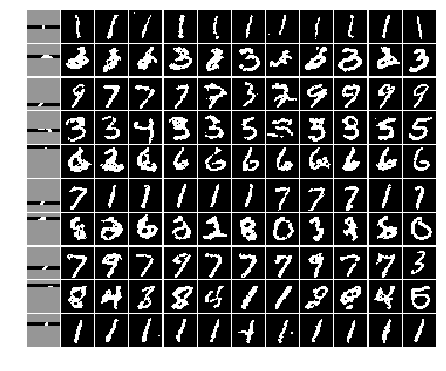

In [17]:
s = 0.5
n = 10
plt.figure(figsize=((n + 2) * s, s * len(res)))
for i in range(len(res)):
    plt.subplot(len(res), (n + 2), i * (n + 2) + 1)
    draw_sample(res[i]['input'])
    for j in range(n):
        plt.subplot(len(res), (n + 2), i * (n + 2) + j + 2)
        draw_sample(res[i]['results'][j])
    plt.subplot(len(res), (n + 2), i * (n + 2) + n + 2)
    draw_sample(res[i]['groundtruth'])
plt.tight_layout(pad=0, w_pad=-2.2, h_pad=-2.2)
plt.savefig('mnist_um.pdf', bbox_inches='tight')

In [18]:
model_um['model'].cuda()
a = test_data.tensors[0][np.random.choice(test_data.tensors[0].shape[0], 10)]
b = generate_horizontal_line_MNIST(10)
%time model_um['model'].generate_samples(a.cuda(), b.cuda(), 100)
model_um['model'].cpu()
pass

CPU times: user 7.56 s, sys: 2.77 s, total: 10.3 s
Wall time: 10.3 s


In [19]:
def chain_rule_log_likelihood_estimation(model, x_true, b, K=1):
    n, d = b.shape
    x_true = x_true.view(n, 1, d).repeat(1, K, 1).view(-1, d)
    b = b.view(n, 1, d).repeat(1, K, 1).view(-1, d)
    res = torch.zeros(b.size(0)).cuda()
    while (b.sum() != 0):
        data = torch.cat([x_true * (1 - b), b], 1)
        x_distr = model.network(Variable(data)).data
        b_sum = b.sum(1, True)
        i_idx = torch.nonzero(b_sum)[:, 0]
        j_idx = torch.multinomial(b[i_idx] / b_sum[i_idx], 1).view(-1)
        add = binary_crossentropy_loss(
            x_true[i_idx, j_idx].view(-1, 1),
            x_distr[i_idx, j_idx].view(-1, 1), torch.ones(i_idx.shape[0], 1).cuda())[:, 0]
        res[i_idx] += add
        b[i_idx, j_idx] = 0
    return float(log_mean_exp(res.view(-1, K)).mean())

In [20]:
model_um['model'].cuda()
%time print(model_test_loss(test_data, generate_horizontal_line_MNIST, \
                            lambda batch, b: \
                            chain_rule_log_likelihood_estimation(model_um['model'], batch, b, K=100), \
                            max_batches=5, batch_size=1, is_cuda=True))
model_um['model'].cpu()
pass

-40.926060040791825
CPU times: user 15.5 s, sys: 393 ms, total: 15.9 s
Wall time: 15.9 s
